# Implementation of Liu et al. 2021 algorithm

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Import Bedretto M0 experiment provisional dataset 
catalog = pd.read_csv('seiscomp-exp-dd_20240415.csv')
catalog_xyz = catalog[['x', 'y', 'z']]
X = catalog_xyz.to_numpy()

## 1. RANSAC method for fracture orientation parameters detection

In [3]:
def plane_eq(pts):
    """ 
    Function to calculate the plane equation in intercept form with intercepts a,b,c
    """

    v1 = pts[1] - pts[0]
    v2 = pts[2] - pts[0]

    normal = np.cross(v1, v2)
    A, B, C = normal

    D = -np.dot(normal, pts[1])

    a = -A / D
    b = -B / D
    c = -C / D

    return a,b,c, normal

In [4]:
def dist_from_plane(x,y,z, a,b,c):
    """ 
    Function to calculate distance from point to plane when plane characterized by intercept-form-equation
    """

    return np.absolute((x/a) + (y/b) + (z/c) - 1) / np.sqrt(1/(a**2) + 1/(b**2) + 1/(c**2))

In [5]:
def orientation(a,b,c):
    """ 
    Function to compute the strike, dip direction, and dip angle of plane from its interecpt-form-equation
    """
    param = [0.0,0.0,0.0]
    
    # strike
    if  np.arctan(-b/a) >= 0:
        param[0] = np.arctan(-b/a)
    else:
        param[0] = np.arctan(-b/a) + np.pi

    # dip direction
    param[1] = np.arctan(np.absolute(c)*np.sqrt((a**2+b**2)/np.absolute(a*b)))

    # dip angle
    if np.sign(a)*np.sign(c)==1 and np.sign(a)*np.sign(b)==1:
        param[2] = param[0] + np.pi/2
    elif np.sign(a)*np.sign(c)==-1:
        param[2] = param[0] + 3*np.pi/2
    elif np.sign(a)*np.sign(c)==1 and np.sign(a)*np.sign(b)==-1:
        param[2] = param[0] - np.pi/2
    
    return param

In [6]:
def ransac_1plane(X, I, s, tau):

    """
    Function to separate dataset into inliers (points fitted to a plane) and outliers 

    --- Inputs ---
    X : 3D point cloud dataset
    I : number of iterations
    tau : distance threshold (if point is less than tau away from plane, it is considered an inlier)
    s : support threshold (a plane is validated if its support, i.e. number of inliers, exceeds s bfore the end of the I iterations)
    
    --- Outputs ---
    Set of inliers (could be empty if plane was not selected before max number of iterations reached)
    param : orientation parameters of plane (if plane selected). Strike, dip direction, and dip angle
    normal : normal vector of selected plane
    Set of outliers

    """

    support = []
    outlier_list = []
    inlier_list = []
    normal_list=[]
    param_list=[]
    pts_list=[]

    inliers = []
    outliers = []
    param = []
    normal=[]


    for i in range(I):
        # randomly select 3 pts and form candidate plane
        idx_samples = random.sample(range(len(X)), 3)
        pts = X[idx_samples]
        a,b,c, normal= plane_eq(pts)
        param_list.append(orientation(a,b,c))
        normal_list.append(normal)
        pts_list.append(pts)

        # find points in dataset that are less than tau away from plane
        x = X[:, 0]
        y = X[:, 1]
        z = X[:, 2]
        dist_values = dist_from_plane(x,y,z, a,b,c)
        filtered_indices = np.where(dist_values < tau)[0]
        unfiltered_indices = np.where(dist_values >= tau)[0]

        inlier_list.append(filtered_indices)
        outlier_list.append(unfiltered_indices)

        # calculate support
        support.append(len(filtered_indices))
    
    max_support = max(support)
    max_index = support.index(max(support))
        
    if max_support >= s:
        # compute orientation parameters of the plane
        param = param_list[max_index]
        normal = normal_list[max_index]
        plane_points = pts_list[max_index]

        # separate dataset into two sets: "inliers" and "outliers"
        inliers = X[inlier_list[max_index]]
        outliers = X[outlier_list[max_index]]

        print(f"Plane with {max_support} inliers and {len(outlier_list[max_index])} outliers detected")
        detection = True
    else:
        print("No plane detected")
        inliers = []
        outliers = X
        param = []
        normal= []
        plane_points = []
        detection = False
    
    return inliers, param, normal, plane_points, outliers, detection

In [7]:
def RANSAC(X, I, s, tau, epsilon):

    """
    Function to implement RANSAC algorithm
    
    --- Inputs ---
    X : 3D point cloud dataset
    I,s,tau : see function ransac_1plane
    epsilon : global desired proportion of outliers (i.e. noise)

    --- Outputs ---
    Set of inlier clusters
    Set of plane orientations
    Outliers/ noise points

    """

    inlier_proportion = 0
    inliers_list = []
    param_list = []
    normal_list=[]
    pts_list = []
    detection=True
    n = len(X)

    # Continue until proportion of inliers/outliers reaches epsilon
    while inlier_proportion < epsilon and detection==True: #or inliers_list[-2]!={}):
        
        # Fit a plane
        inliers, param, normal, plane_points, outliers, detection = ransac_1plane(X, I, s, tau)

        if len(inliers)>0:
            inlier_proportion = (n - len(outliers))/len(outliers)
            inliers_list.append(inliers)
            param_list.append(param)
            normal_list.append(normal)
            pts_list.append(plane_points)

        # Update dataset by removing inliers
        X = outliers 
    
    return inliers_list, param_list, normal_list, pts_list, outliers

In [8]:
def plot_clusters_and_noise(inliers_list, outliers, noisy):
    """
    Function to plot the 3D clusters with different colors and the noise points in gray.
    
    --- Inputs ---
    inliers_list : list of sets
        A list where each element is a set of inliers (3D points).
    outliers : set
        A set of outlier points (3D points).
        
    --- Outputs ---
    fig : matplotlib.figure.Figure
        The 3D plot figure.

    """
    colors = plt.cm.tab20(np.linspace(0, 1, len(inliers_list)))
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
    
    # 3D plot (top left)
    ax = fig.add_subplot(221, projection='3d')
    for idx, inliers in enumerate(inliers_list):
        inliers_array = np.array(list(inliers))
        ax.scatter(inliers_array[:, 0], inliers_array[:, 1], inliers_array[:, 2], color=colors[idx], label=f'Cluster {idx+1}', s=10)  # Adjusted size to 10
    
    # Plot outliers in gray
    if noisy==True:
        if len(outliers) > 0:
            outliers_array = np.array(list(outliers))
            ax.scatter(outliers_array[:, 0], outliers_array[:, 1], outliers_array[:, 2], color='gray', label='Noise', alpha=0.5, s=10)  # Adjusted size to 10
    
    if noisy==True:
        ax.set_title('3D Clusters and Noise')
    else:
        ax.set_title('3D Clusters without Noise')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    #ax.legend()
    
    # Combine all points for PCA
    all_points = np.concatenate([np.array(list(points)) for points in inliers_list] + [np.array(list(outliers))])
    pca = PCA(n_components=3)
    pca_points = pca.fit_transform(all_points)
    
    # PC1 vs PC2 (top right)
    ax2 = fig.add_subplot(222)
    for idx, inliers in enumerate(inliers_list):
        inliers_array = np.array(list(inliers))
        inliers_pca = pca.transform(inliers_array)
        ax2.scatter(inliers_pca[:, 0], inliers_pca[:, 1], color=colors[idx], label=f'Cluster {idx+1}', s=10)  # Adjusted size to 10
    
    if noisy==True:
        if len(outliers) > 0:
            outliers_pca = pca.transform(np.array(list(outliers)))
            ax2.scatter(outliers_pca[:, 0], outliers_pca[:, 1], color='gray', label='Noise', alpha=0.5, s=10)  # Adjusted size to 10
    
    ax2.set_title('PC1 vs PC2')
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    #ax2.legend()
    
    # PC1 vs PC3 (bottom left)
    ax3 = fig.add_subplot(223)
    for idx, inliers in enumerate(inliers_list):
        inliers_array = np.array(list(inliers))
        inliers_pca = pca.transform(inliers_array)
        ax3.scatter(inliers_pca[:, 0], inliers_pca[:, 2], color=colors[idx], label=f'Cluster {idx+1}', s=10)  # Adjusted size to 10
    
    if noisy==True:
        if len(outliers) > 0:
            outliers_pca = pca.transform(np.array(list(outliers)))
            ax3.scatter(outliers_pca[:, 0], outliers_pca[:, 2], color='gray', label='Noise', alpha=0.5, s=10)  # Adjusted size to 10
    
    ax3.set_title('PC1 vs PC3')
    ax3.set_xlabel('Principal Component 1')
    ax3.set_ylabel('Principal Component 3')
    #ax3.legend()
    
    # PC2 vs PC3 (bottom right)
    ax4 = fig.add_subplot(224)
    for idx, inliers in enumerate(inliers_list):
        inliers_array = np.array(list(inliers))
        inliers_pca = pca.transform(inliers_array)
        ax4.scatter(inliers_pca[:, 1], inliers_pca[:, 2], color=colors[idx], label=f'Cluster {idx+1}', s=10)  # Adjusted size to 10
    
    if noisy==True:
        if len(outliers) > 0:
            outliers_pca = pca.transform(np.array(list(outliers)))
            ax4.scatter(outliers_pca[:, 1], outliers_pca[:, 2], color='gray', label='Noise', alpha=0.5, s=10)  # Adjusted size to 10
    
    ax4.set_title('PC2 vs PC3')
    ax4.set_xlabel('Principal Component 2')
    ax4.set_ylabel('Principal Component 3')
    #ax4.legend()
    
    plt.tight_layout()
    return fig

In [9]:
def min_iter(q, epsilon):
    """ 
    Function to find the minimum number of iteration required in ransac_1plane

    --- Inputs ---
    q : probability of yielding an accurate estimation of fracture parameters by a random sampling from dataset
        1-q = probability of picking a sample with at least one true outlier (false positive)
    epsilon : proportion of true inliers of the dataset (unknown but can put estimate)

    --- Outputs ---
    min number of iterations required
    """
    min = np.log(1-q) / np.log(1 - epsilon**3)    

    return min

In [55]:
min_iter(0.5, 0.5)

5.1908930696844315

In [10]:
""" 
Test on M0 dataset
"""
inliers_list, param_list, normal_list, pts_list, outliers = RANSAC(X, I=5000, s=200, tau=0.2, epsilon=2)
#ransac_1plane(X, I=1000, s=500, tau=0.5)


Plane with 975 inliers and 7038 outliers detected
Plane with 440 inliers and 6598 outliers detected
Plane with 882 inliers and 5716 outliers detected
Plane with 506 inliers and 5210 outliers detected
Plane with 451 inliers and 4759 outliers detected
Plane with 247 inliers and 4512 outliers detected
Plane with 383 inliers and 4129 outliers detected
Plane with 292 inliers and 3837 outliers detected
Plane with 244 inliers and 3593 outliers detected
Plane with 221 inliers and 3372 outliers detected
Plane with 202 inliers and 3170 outliers detected
No plane detected


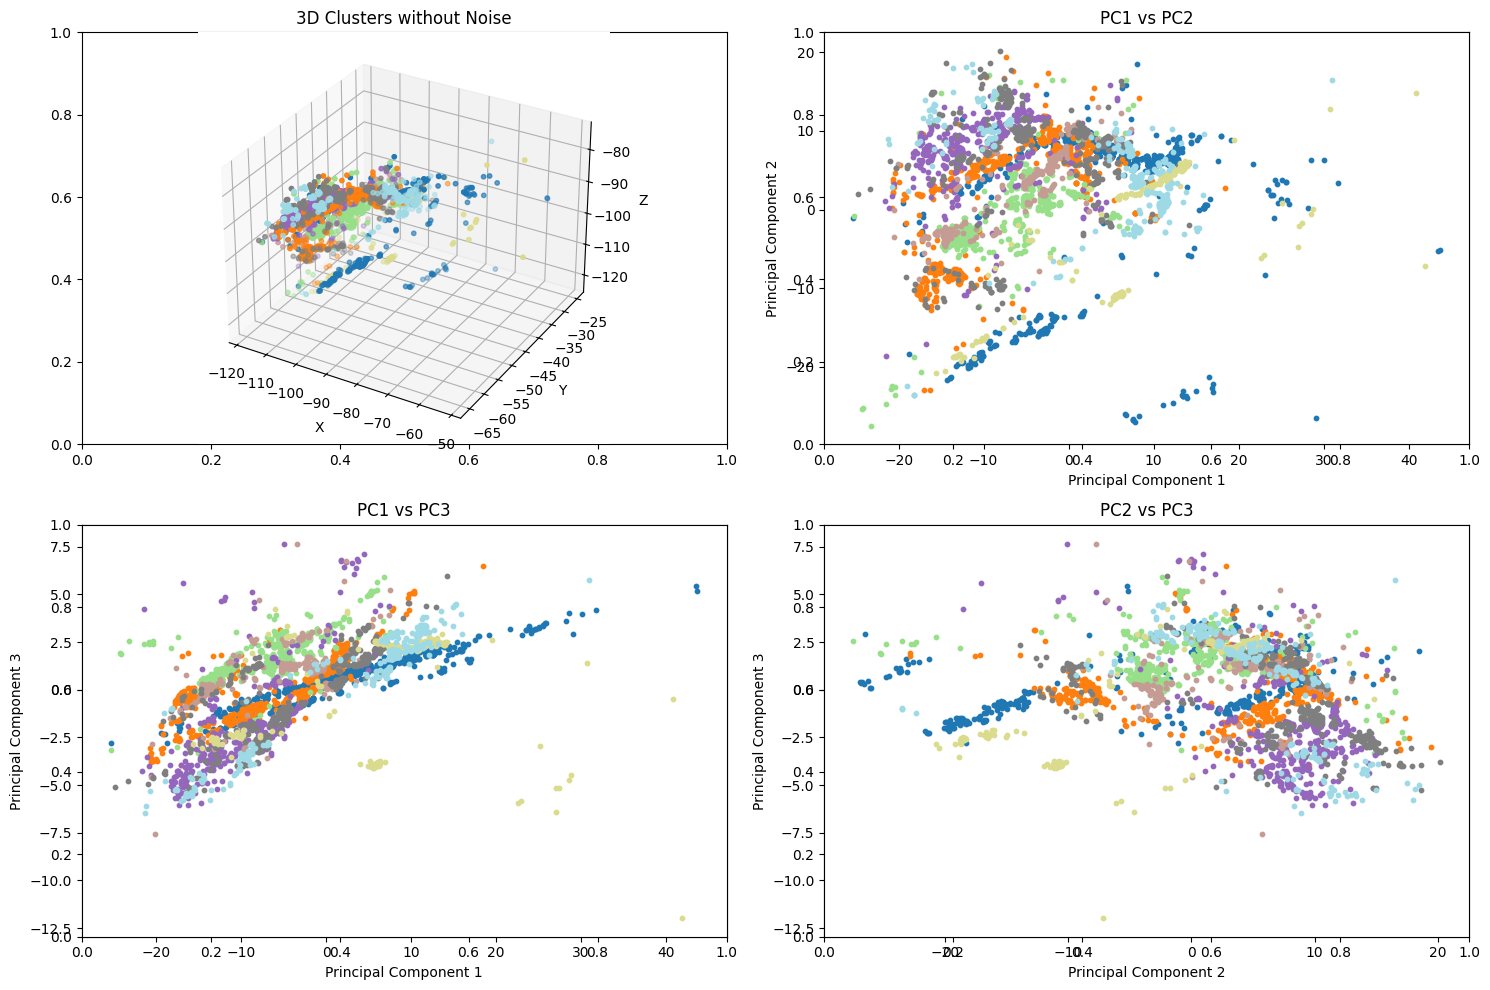

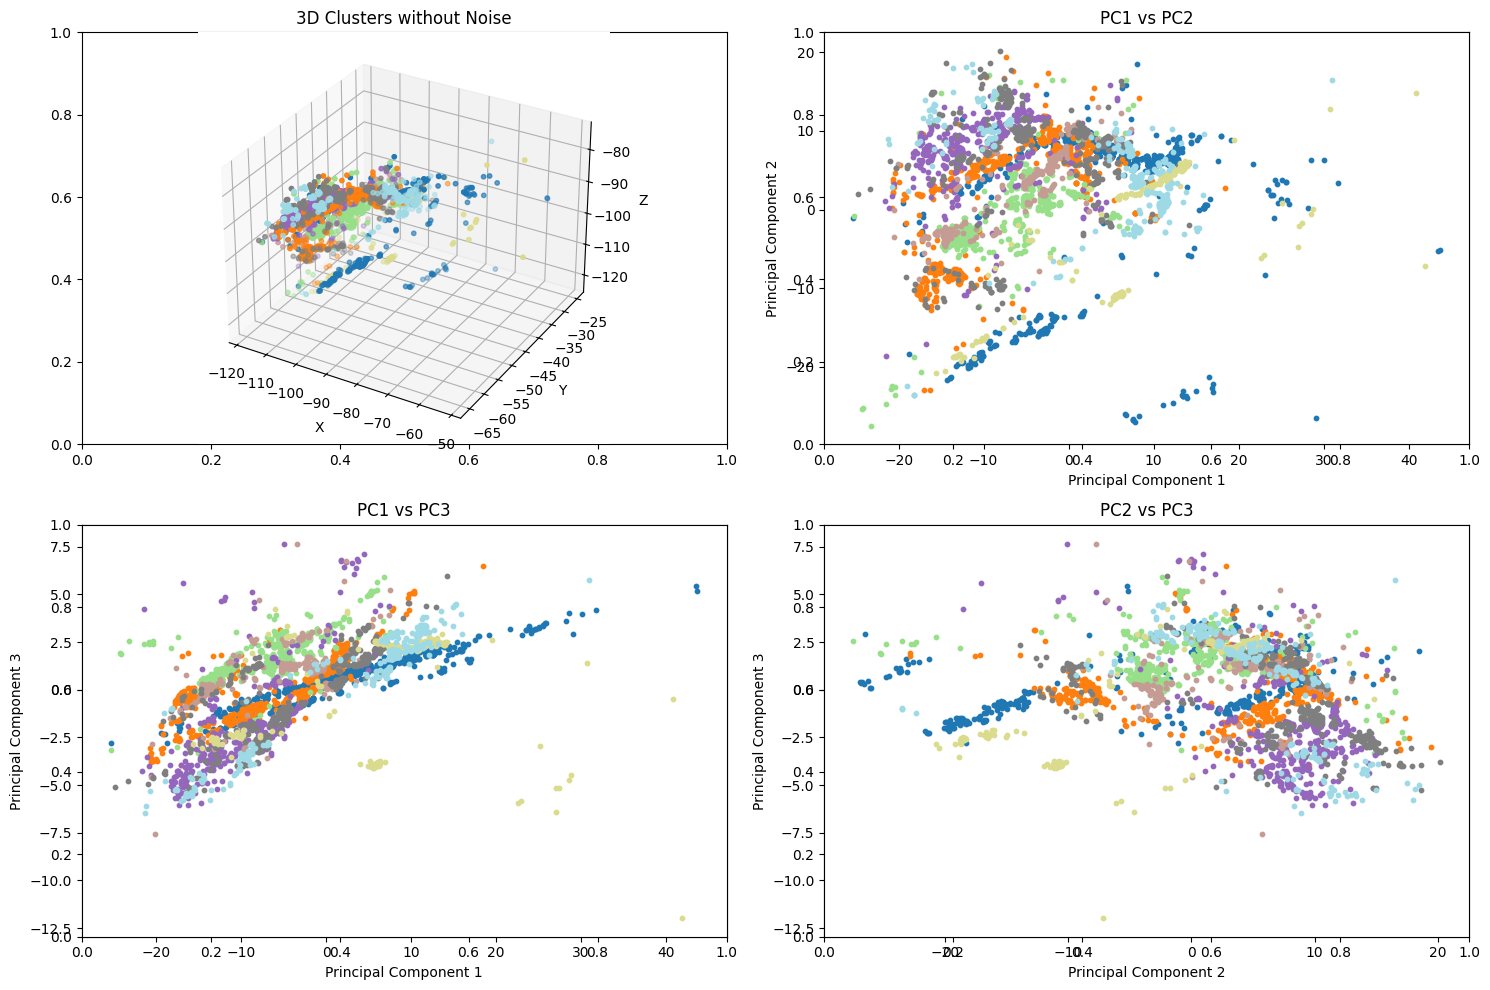

In [282]:
plot_clusters_and_noise(inliers_list, outliers, noisy=False)

### Test on X_orth dataset

In [11]:
orth = pd.read_csv('toy-orthogonal.csv')
X_orth = orth[['x', 'y', 'z']].values
clusters_orth = orth['cluster'].values

In [21]:
inliers_list, param_list, normal_list, pts_list, outliers = RANSAC(X_orth, I=5000, s=40, tau=2, epsilon=2)

Plane with 59 inliers and 3301 outliers detected
Plane with 65 inliers and 3236 outliers detected
Plane with 53 inliers and 3183 outliers detected
Plane with 56 inliers and 3127 outliers detected
Plane with 51 inliers and 3076 outliers detected
Plane with 61 inliers and 3015 outliers detected
Plane with 51 inliers and 2964 outliers detected
Plane with 56 inliers and 2908 outliers detected
Plane with 45 inliers and 2863 outliers detected
Plane with 43 inliers and 2820 outliers detected
Plane with 48 inliers and 2772 outliers detected
No plane detected


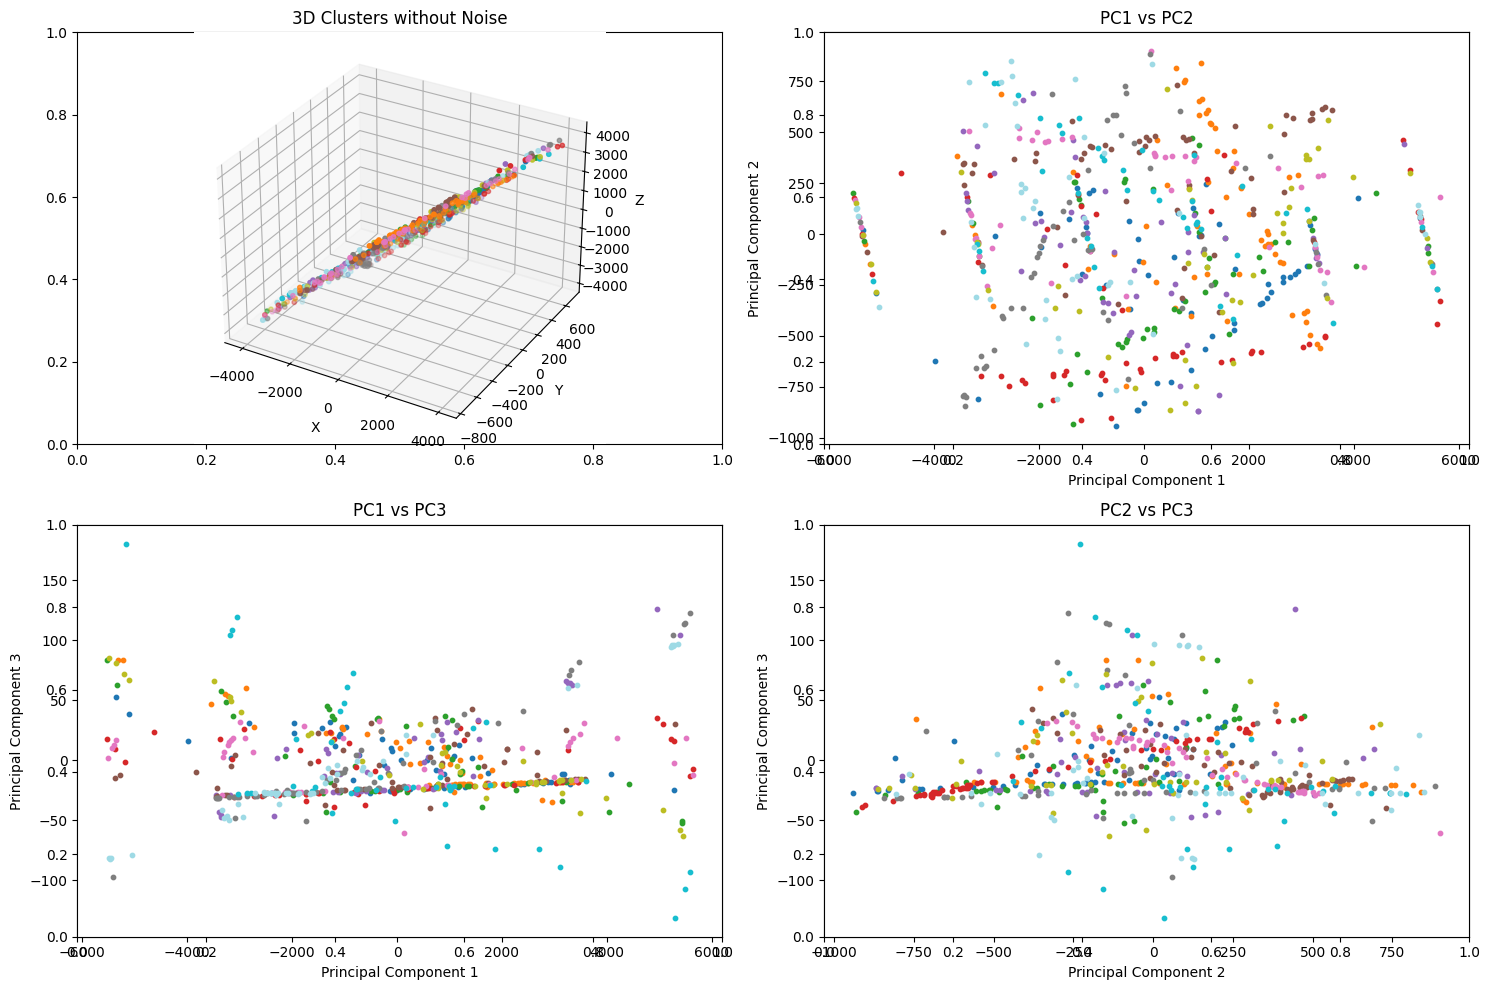

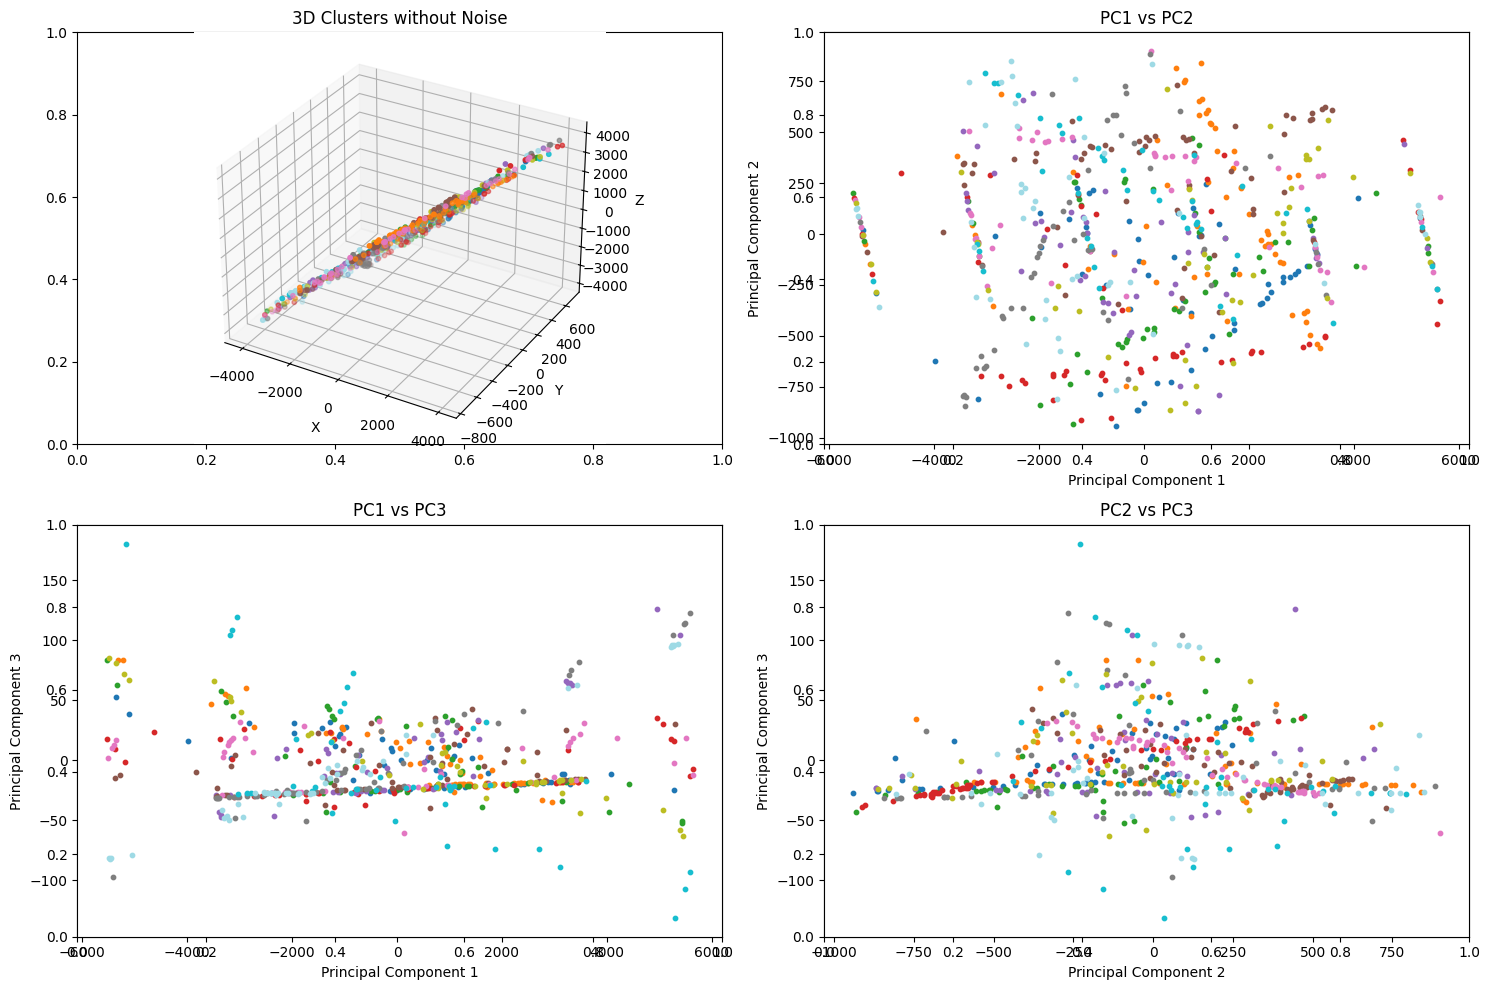

In [22]:
plot_clusters_and_noise(inliers_list, outliers, noisy=False)

## 2. Alpha-shape method for fracture geometry parameters detection

Remark : when alpha -> 0, alpha shape -> point set and when alpha -> inf, alpha shape -> convex hull.

In [57]:
from scipy.spatial import Delaunay
from scipy.spatial import QhullError
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [62]:
def compute_alpha_shape(points, alpha):
    """
    Function to compute the alpha shape (concave hull) of a set of 3D points.
    
    --- Inputs ---
    points : np.ndarray
        An array of shape (n, 3) representing the 3D point cloud.
    alpha : float
        The alpha parameter to control the shape. Smaller values lead to more detailed shapes.
        
    --- Outputs ---
    vertices : list
        List of vertices of the alpha shape.
    simplices : list
        List of simplices (triangles) forming the alpha shape.
    """
    if len(points) < 4:
        raise ValueError("Need at least four points for 3D alpha shape")

    tetra = Delaunay(points)
    tetrahedrons = tetra.simplices
    vertices = points[tetrahedrons]
    
    # Circumradii calculation
    a = np.linalg.norm(vertices[:, 1] - vertices[:, 0], axis=1)
    b = np.linalg.norm(vertices[:, 2] - vertices[:, 0], axis=1)
    c = np.linalg.norm(vertices[:, 2] - vertices[:, 1], axis=1)
    d = np.linalg.norm(vertices[:, 3] - vertices[:, 0], axis=1)
    e = np.linalg.norm(vertices[:, 3] - vertices[:, 1], axis=1)
    f = np.linalg.norm(vertices[:, 3] - vertices[:, 2], axis=1)
    
    volume = np.abs(np.einsum('ij,ij->i', np.cross(vertices[:, 1] - vertices[:, 0], vertices[:, 2] - vertices[:, 0]), vertices[:, 3] - vertices[:, 0])) / 6
    circumradii = a * b * c * d * e * f / (24 * volume)
    
    # Filter tetrahedrons by circumradius
    alpha_shape = tetrahedrons[circumradii < alpha]
    
    # Extract the boundary triangles of the alpha shape
    triangles = []
    for simplex in alpha_shape:
        for i in range(4):
            face = np.sort(simplex[np.array([j for j in range(4) if j != i])])
            triangles.append(face)
    
    triangles = np.array(triangles)
    triangles = np.unique(triangles, axis=0)
    
    return points, triangles

In [66]:
def plot_alpha_shape(points, triangles):
    """
    Plot the alpha shape using the provided triangles.
    
    Parameters:
    points : np.ndarray
        Array of points in the shape.
    triangles : list
        List of triangles forming the alpha shape.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', marker='o', alpha=0.5, s=10)  # Plot points

    if len(triangles) > 0:
        for triangle in triangles:
            tri_points = points[triangle]
            tri = Poly3DCollection([tri_points])
            tri.set_color(np.random.rand(3,))
            tri.set_edgecolor('k')
            ax.add_collection3d(tri)
    
    ax.set_xlabel('East')
    ax.set_ylabel('North')
    ax.set_zlabel('Up')
    ax.set_title('Alpha Shape 3D Plot')
    plt.show()


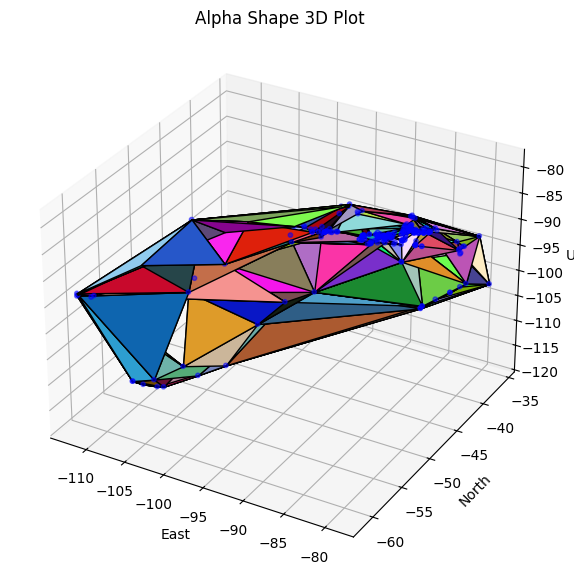

In [215]:
# Example usage 

# Compute alpha shape
alpha = 30000
vertices, triangles = compute_alpha_shape(inliers_list[-1], alpha)

# Plot alpha shape
plot_alpha_shape(vertices, triangles)


In [86]:
def plot_multiple_alpha_shapes(cluster_list, outliers, alpha, noisy):
    """
    Plot multiple alpha shapes using the provided clusters.
    
    Parameters:
    cluster_list : list of np.ndarray
        List of arrays representing the 3D point clouds.
    alpha : float
        The alpha parameter to control the shape. Smaller values lead to more detailed shapes.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = plt.get_cmap('tab10', len(cluster_list))  # Get a colormap
    
    for idx, points in enumerate(cluster_list):
        vertices, triangles = compute_alpha_shape(points, alpha)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=colors(idx), marker='o', alpha=0.5, s=10)  # Plot points

        if len(triangles) > 0:
            for triangle in triangles:
                tri_points = vertices[triangle]
                tri = Poly3DCollection([tri_points])
                tri.set_color(colors(idx))
                tri.set_edgecolor('k')
                ax.add_collection3d(tri)

    # Plot outliers in gray
    if noisy ==True :
        if len(outliers) > 0:
            ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], color='gray', marker='x', alpha=0.5, s=10, label='Outliers')
    
    ax.set_xlabel('East')
    ax.set_ylabel('North')
    ax.set_zlabel('Up')
    ax.set_title('Multiple Alpha Shapes 3D Plot')
    plt.show()

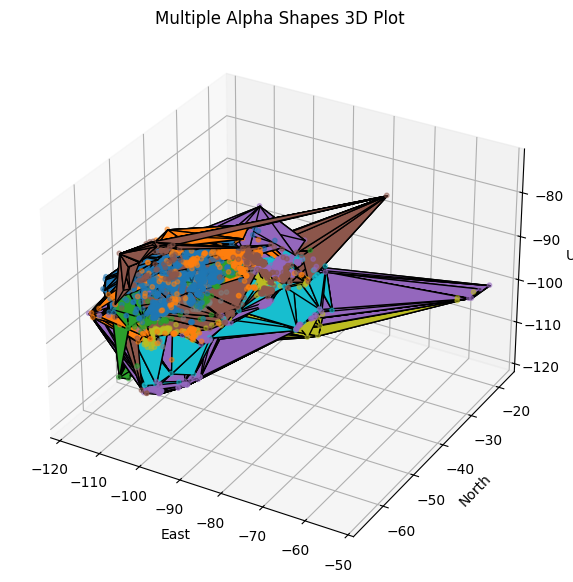

In [216]:
plot_multiple_alpha_shapes(inliers_list, outliers, alpha, noisy = False)

## 3. DBSCAN method for denoising of fracture geometry detection

Assumption : "the denoising work may be equivalent to the separation of high-density regions from low-density regions in microseismic events clouds" because "effective events often present relatively concentrated distribution with high density while the noise events often have scattered distribution with low density" (Liu et al. 2021).

In [220]:
from scipy.spatial import distance

In [386]:
def dbscan_3d(X, eps, min_samples):
    """
    Perform DBSCAN clustering from vector array or distance matrix.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The input 3D data.
    eps : float
        The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    min_samples : int
        The number of samples in a neighborhood for a point to be considered as a core point.
        
    Returns
    -------
    core_samples_indices : array, shape (n_core_samples,)
        Indices of core samples.
    labels : array, shape (n_samples,)
        Cluster labels for each point in the dataset. Noisy samples are given the label -1.
    """
    n_samples = X.shape[0]
    labels = np.full(n_samples, -1)  # Initialize labels as -1 (noise)
    core_samples_indices = []

    # Compute the distance matrix
    dists = distance.squareform(distance.pdist(X))
    
    # Determine the core samples
    for i in range(n_samples):
        if labels[i] == -1:  # Unvisited
            # Find neighbors
            neighbors = np.where(dists[i] <= eps)[0]
            if len(neighbors) >= min_samples:
                core_samples_indices.append(i)
                # Create a new cluster
                labels[i] = len(core_samples_indices) - 1
                expand_cluster(X, labels, core_samples_indices[-1], neighbors, eps, min_samples, dists)
    
    return np.array(core_samples_indices), labels


In [385]:
def expand_cluster(X, labels, core_index, neighbors, eps, min_samples, dists):
    """
    Expand the cluster from the core point.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The input 3D data.
    labels : array, shape (n_samples,)
        Cluster labels for each point in the dataset.
    core_index : int
        Index of the core point.
    neighbors : array, shape (n_neighbors,)
        Indices of the neighbors of the core point.
    eps : float
        The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    min_samples : int
        The number of samples in a neighborhood for a point to be considered as a core point.
    dists : array, shape (n_samples, n_samples)
        The distance matrix of the dataset.
    """
    cluster_label = labels[core_index]
    i = 0
    while i < len(neighbors):
        point = neighbors[i]
        if labels[point] == -1:  # Unvisited
            labels[point] = cluster_label
            point_neighbors = np.where(dists[point] <= eps)[0]
            if len(point_neighbors) >= min_samples:
                neighbors = np.concatenate([neighbors, point_neighbors])
        elif labels[point] == -1:
            labels[point] = cluster_label
        i += 1

In [237]:
def plot_dbscan(X, labels):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(221, projection='3d')
    
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        xyz = X[class_member_mask]
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker='o', s=10, alpha=0.5)

    ax.set_title('DBSCAN 3D Clustering')

    # Plot the 2D projections
    ax2 = fig.add_subplot(222)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        ax2.scatter(xy[:, 0], xy[:, 1], c=[col], marker='o', s=10, alpha=0.5)
    ax2.set_title('DBSCAN 2D Clustering (PC1 vs PC2)')

    ax3 = fig.add_subplot(223)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xz = X[class_member_mask]
        ax3.scatter(xz[:, 0], xz[:, 2], c=[col], marker='o', s=10, alpha=0.5)
    ax3.set_title('DBSCAN 2D Clustering (PC1 vs PC3)')

    ax4 = fig.add_subplot(224)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        yz = X[class_member_mask]
        ax4.scatter(yz[:, 1], yz[:, 2], c=[col], marker='o', s=10, alpha=0.5)
    ax4.set_title('DBSCAN 2D Clustering (PC2 vs PC3)')

    plt.show()

In [ ]:
# Test on one cluster from inliers_list

core_samples_indices, labels = dbscan_3d(inliers_list[2], eps=1, min_samples=10)

In [249]:
noise_mask = (labels==-1)
inliers_list[2][noise_mask]

array([[-101.93163941,  -56.10401251,  -86.99977   ],
       [ -94.56986937,  -45.09720586,  -91.7551386 ],
       [ -97.19463296,  -47.0689788 ,  -92.8746121 ],
       [-101.05565887,  -55.7747019 ,  -86.0614663 ],
       [-106.58348097,  -60.38511137,  -88.3580985 ],
       [ -91.24683315,  -45.78206214,  -85.6360805 ],
       [-100.85621767,  -49.07382388,  -96.1519135 ],
       [-100.59212423,  -48.86242701,  -96.660449  ],
       [-101.21728907,  -53.35483271,  -90.4525376 ],
       [-105.92991654,  -60.62430638,  -87.3437681 ],
       [-103.40906113,  -55.68804406,  -91.0684684 ],
       [-109.14915574,  -63.7358371 ,  -87.969648  ],
       [-111.75183936,  -58.1382099 , -100.7586629 ],
       [-100.55646747,  -48.30440661,  -96.6797513 ],
       [-108.01054408,  -63.29895092,  -86.258164  ],
       [-101.63443755,  -48.1631389 ,  -99.3613326 ],
       [ -84.62969071,  -35.55941009,  -89.7092597 ],
       [-101.85692065,  -48.12930184,  -99.4839942 ],
       [-102.60671466,  -46.

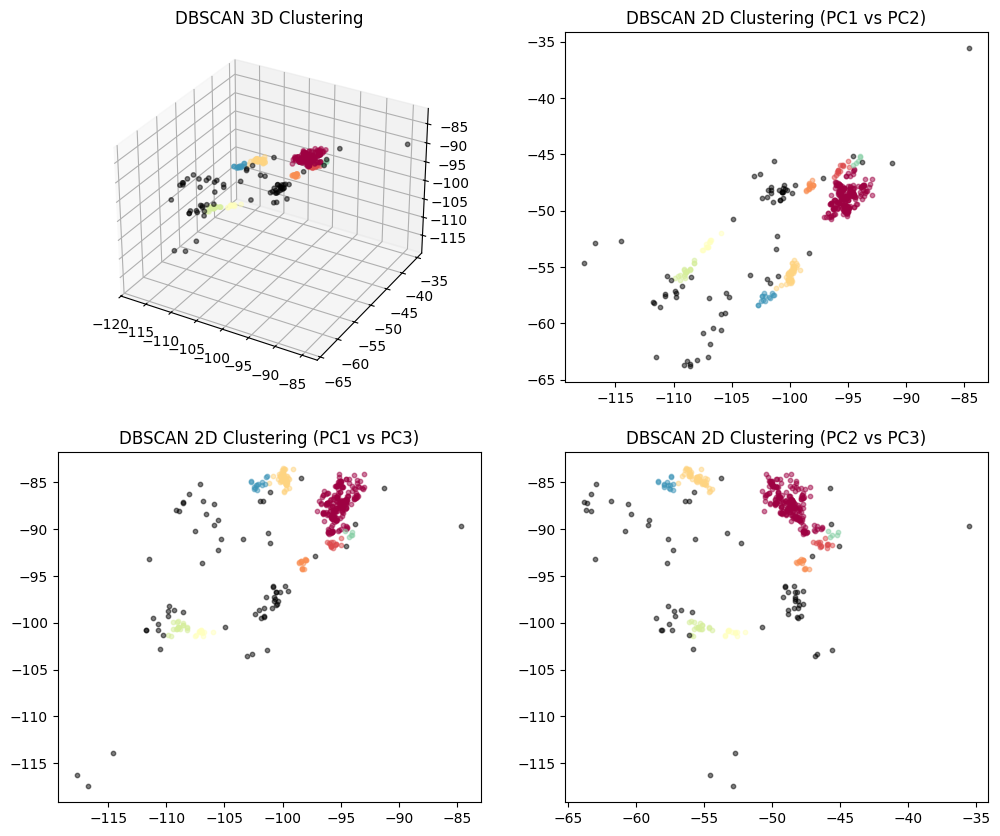

In [245]:
plot_dbscan(inliers_list[2], labels)

In [252]:
def dbscan_denoising(inliers_list, outliers, eps, min_samples):

    """ 
    Function to denoise the geometry of the previously detected fracture planes. 
    The function applies dbscan to each "inlier" cluster, removes the "noise" which is found (low density areas) 
    and adds it to the "outliers" (noise found during the ransac fracture orientation parameters detection)

    --- Inputs ---
    List of inlier clusters (planes)
    Outliers (noise)

    --- Outputs ---
    Denoised list of planar clusters
    Updated noise points
    
    """

    denoised_inliers_list = []
    
    for i in range(len(inliers_list)):

        core_samples_indices, labels = dbscan_3d(inliers_list[i], eps, min_samples)
        noise_mask = (labels==-1)
        outliers = np.append(outliers, inliers_list[i][noise_mask], axis=0)
        inlier_mask = (labels!=-1)
        denoised_inliers_list.append(inliers_list[i][inlier_mask])

    return denoised_inliers_list, outliers 

In [254]:
denoised_inliers_list, updated_outliers = dbscan_denoising(inliers_list, outliers, eps=3, min_samples=10)

In [257]:
len(updated_outliers)

3806

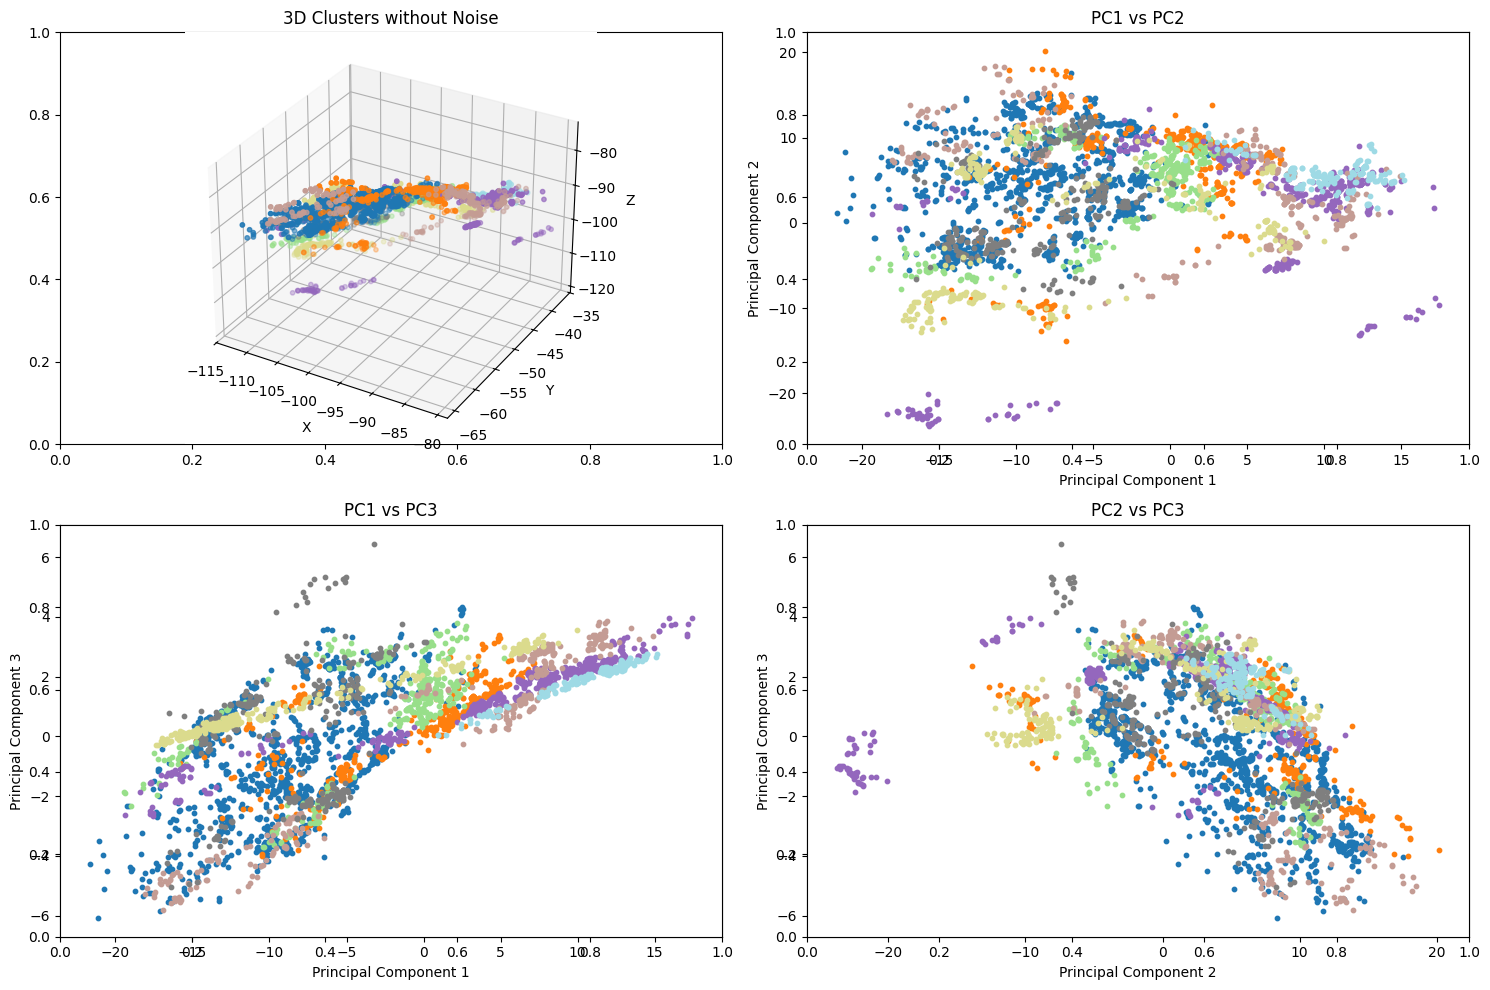

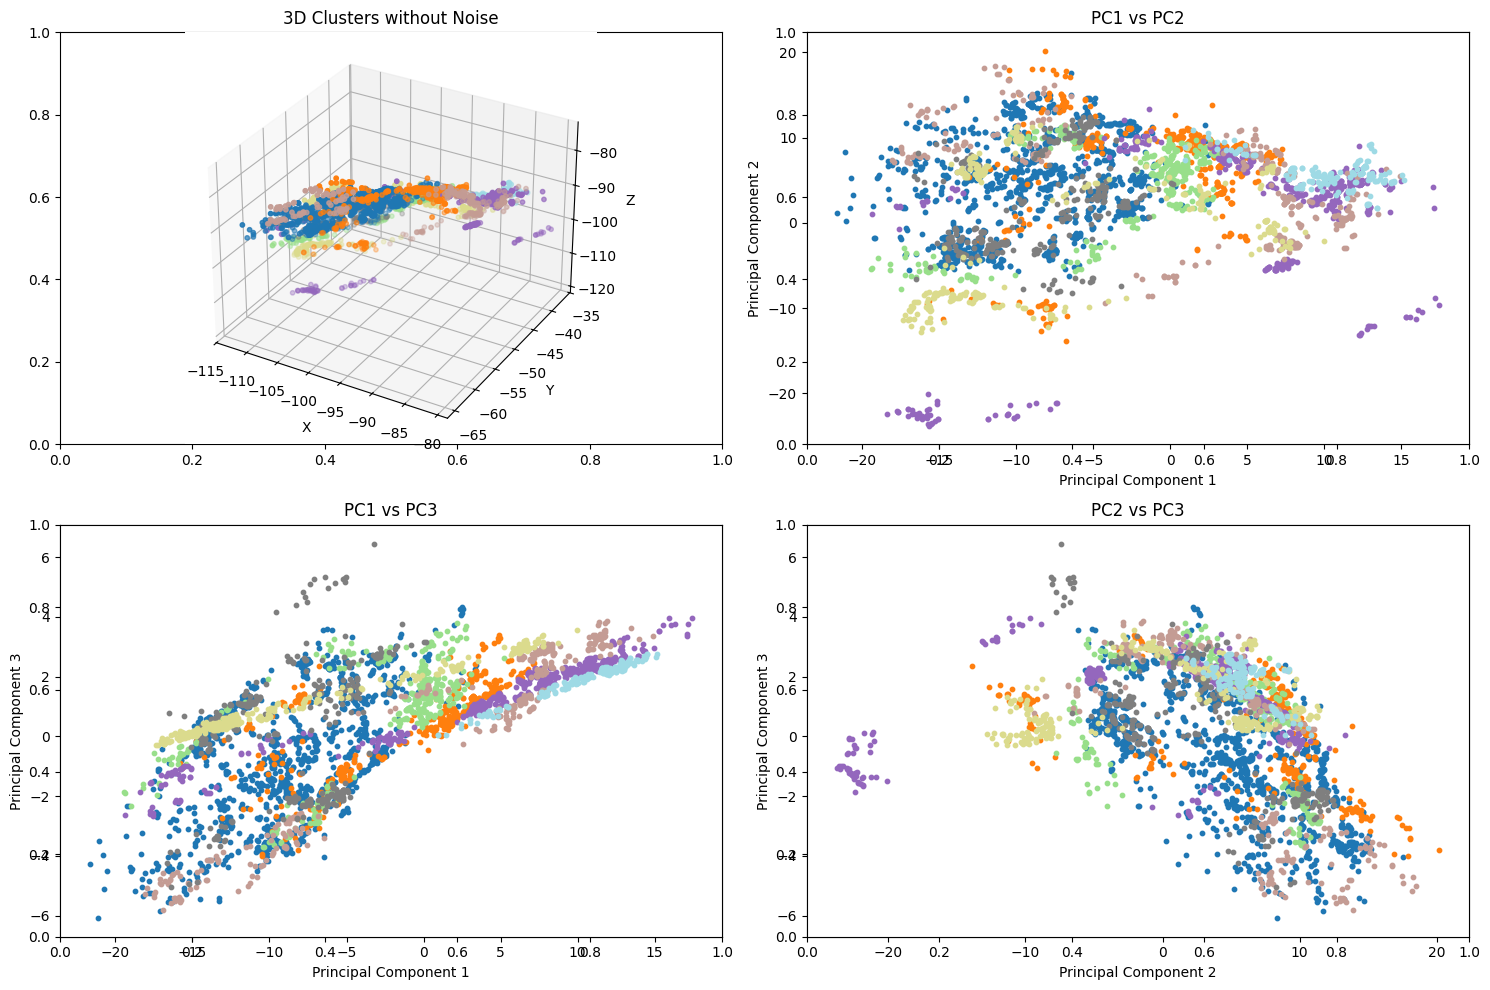

In [258]:
plot_clusters_and_noise(denoised_inliers_list, updated_outliers, noisy=False)

## Visualization

In [286]:
def project_points_onto_plane(points, normal, point_on_plane):
    normal = normal / np.linalg.norm(normal)
    projected_points = points - np.outer(np.dot(points - point_on_plane[0], normal), normal)
    return projected_points

In [287]:
projected_inliers_list = []
for i, (normal, points_in_plane, points) in enumerate(zip(normal_list, pts_list, denoised_inliers_list)):
    projected_points = project_points_onto_plane(points, normal, points_in_plane)
    projected_inliers_list.append(projected_points)

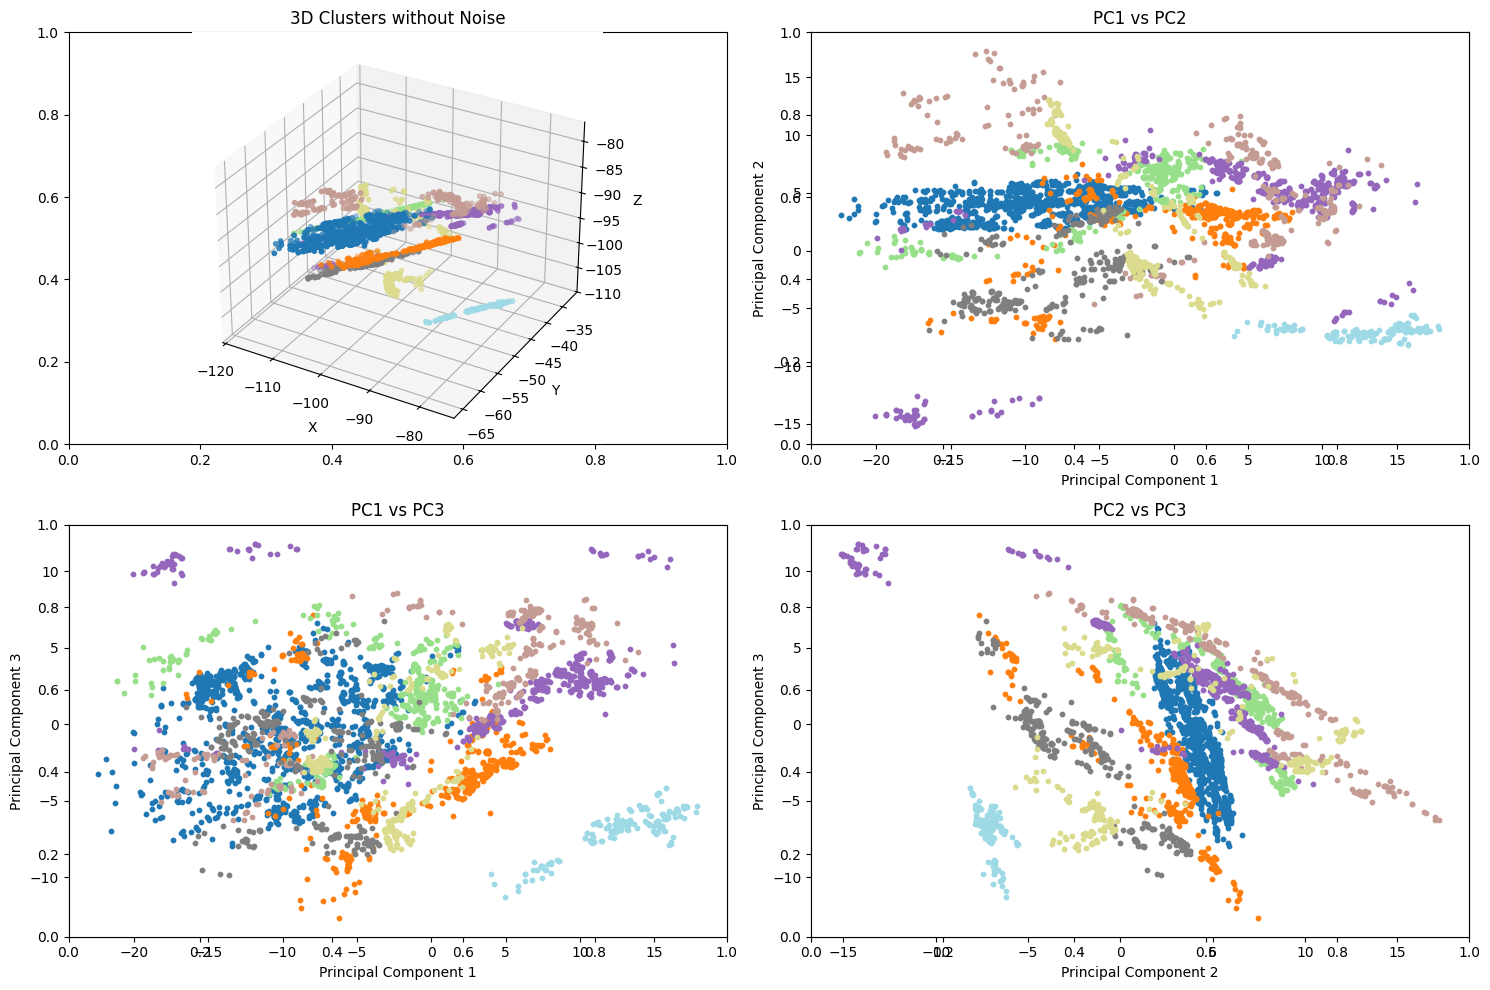

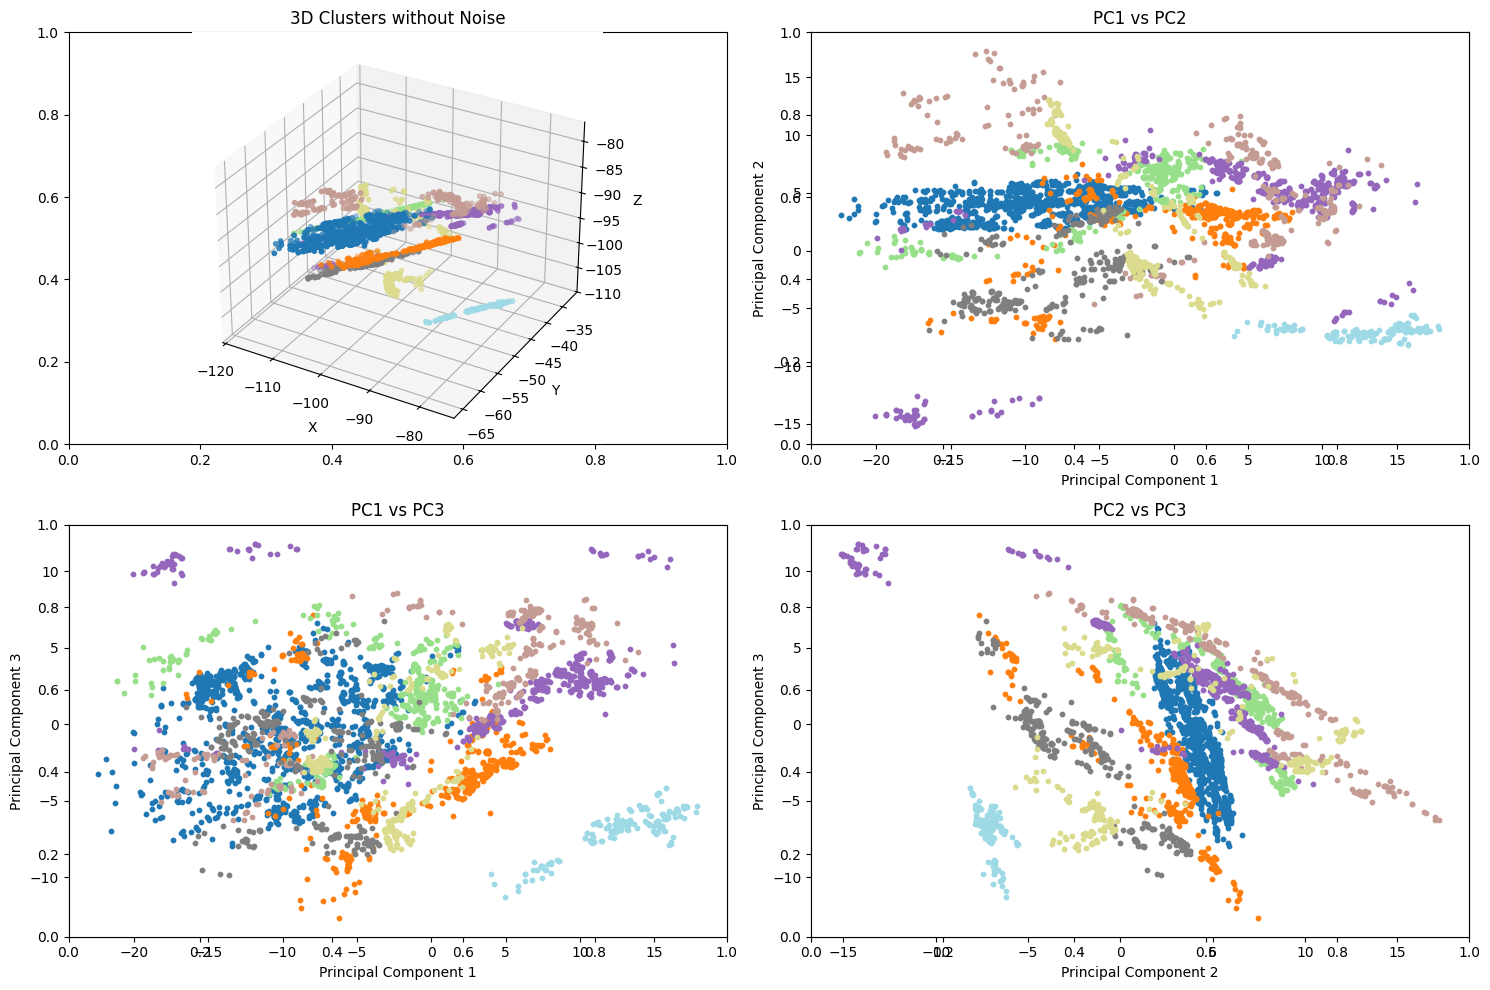

In [293]:
plot_clusters_and_noise(projected_inliers_list, updated_outliers, noisy=False)

In [296]:
from ipywidgets import interactive, FloatSlider

In [298]:
def update_plot(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points
    ax.scatter(projected_inliers_list[0][:, 0], projected_inliers_list[0][:, 1], projected_inliers_list[0][:, 2], c='b', marker='o')
    
    # Set view angles
    ax.view_init(elev=elevation, azim=azimuth)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

# Create interactive plot
interactive_plot = interactive(update_plot, 
                               elevation=FloatSlider(min=0, max=90, step=1, value=30),
                               azimuth=FloatSlider(min=0, max=360, step=1, value=30))
interactive_plot

interactive(children=(FloatSlider(value=30.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

In [301]:
def update_plot(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Get a colormap
    num_clusters = len(projected_inliers_list)
    cmap = plt.get_cmap('hsv', num_clusters)
    
    for i, points in enumerate(projected_inliers_list):
        # Get color for the current cluster
        color = cmap(i)
        
        # Plot the points
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=color, marker='o', s=10)
    
    # Set view angles
    ax.view_init(elev=elevation, azim=azimuth)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

# Create interactive plot
interactive_plot = interactive(update_plot, 
                               elevation=FloatSlider(min=0, max=90, step=1, value=30),
                               azimuth=FloatSlider(min=0, max=360, step=1, value=30))
interactive_plot


interactive(children=(FloatSlider(value=30.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

In [302]:
def update_plot(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Get a colormap
    num_clusters = len(denoised_inliers_list)
    cmap = plt.get_cmap('hsv', num_clusters)
    
    for i, points in enumerate(denoised_inliers_list):
        # Get color for the current cluster
        color = cmap(i)
        
        # Plot the points
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=color, marker='o', s=10)
    
    # Set view angles
    ax.view_init(elev=elevation, azim=azimuth)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

# Create interactive plot
interactive_plot = interactive(update_plot, 
                               elevation=FloatSlider(min=0, max=90, step=1, value=30),
                               azimuth=FloatSlider(min=0, max=360, step=1, value=30))
interactive_plot


interactive(children=(FloatSlider(value=30.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

In [305]:
normal_list[0]

array([ 11.14511555,  -6.98047519, -61.92774195])

In [308]:
inliers_list[0]

array([[ -88.38921194,  -45.56193741,  -87.1648688 ],
       [ -96.55991131,  -50.6571121 ,  -85.8903464 ],
       [ -89.60206512,  -44.98530856,  -99.482111  ],
       ...,
       [ -95.26032697,  -50.03098616,  -85.6657624 ],
       [ -75.25348597,  -35.67521228, -100.4235852 ],
       [ -89.45118381,  -47.14797454,  -77.6931242 ]])

## Test on synthetic dataset


In [329]:
# test on toy dataset 
toy = pd.read_csv('toy-2planes.csv')
X_toy = toy[['x', 'y', 'z']].values
clusters_toy = toy['cluster'].values

In [381]:
inliers_list, param_list, normal_list, pts_list, outliers = RANSAC(X_toy, I=5000, s=80, tau=12, epsilon=20)

Plane with 134 inliers and 380 outliers detected
Plane with 96 inliers and 284 outliers detected
No plane detected


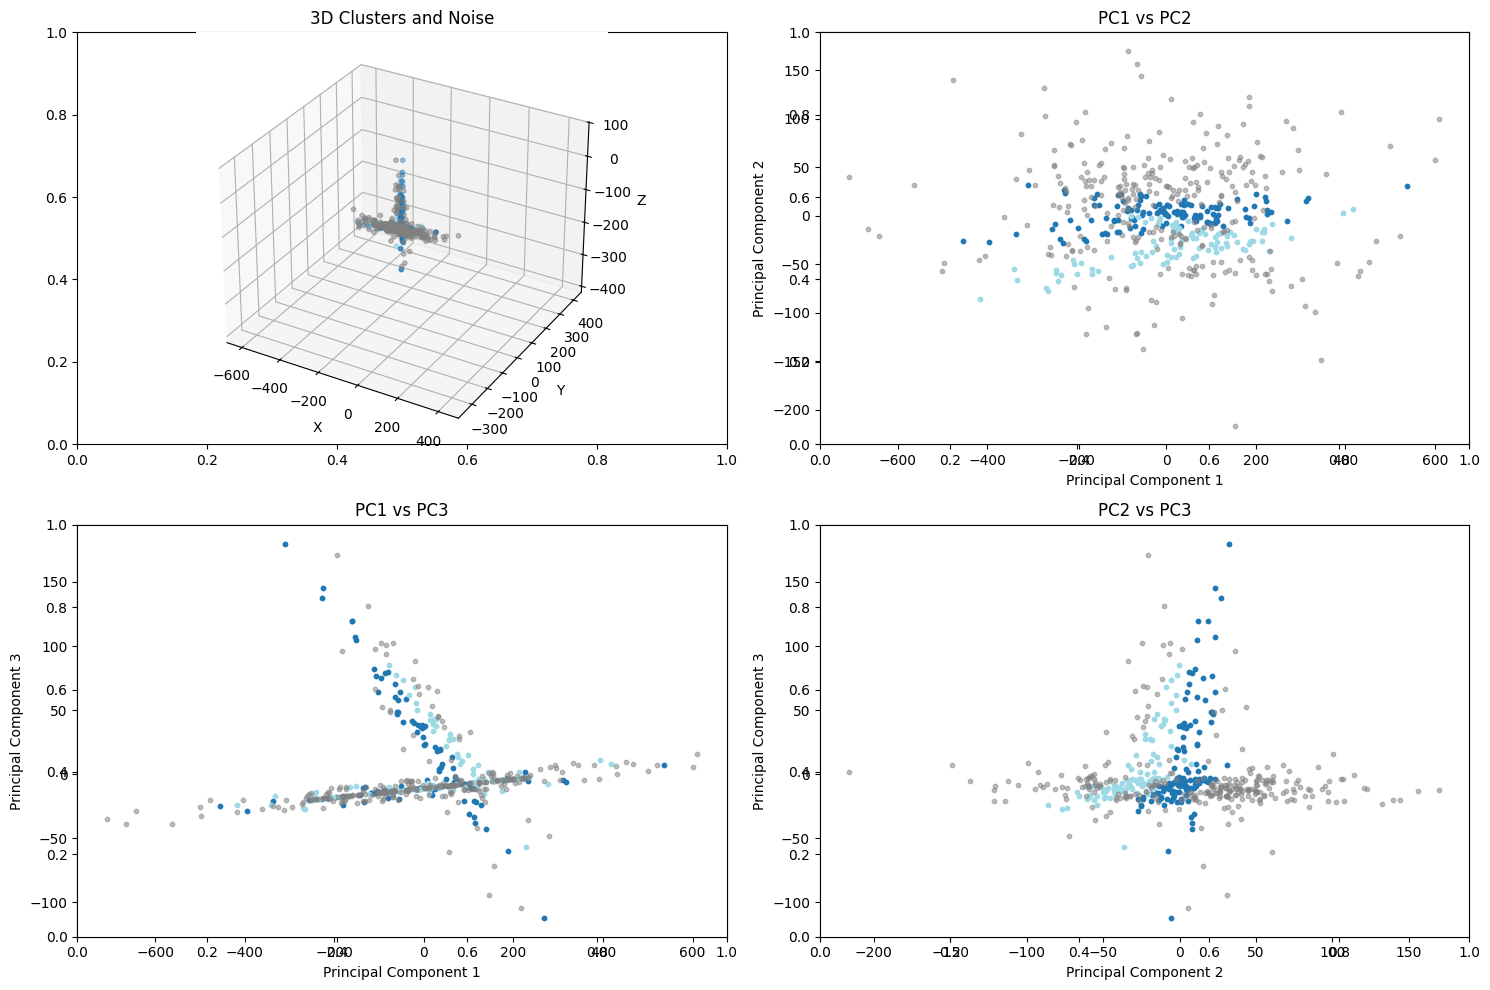

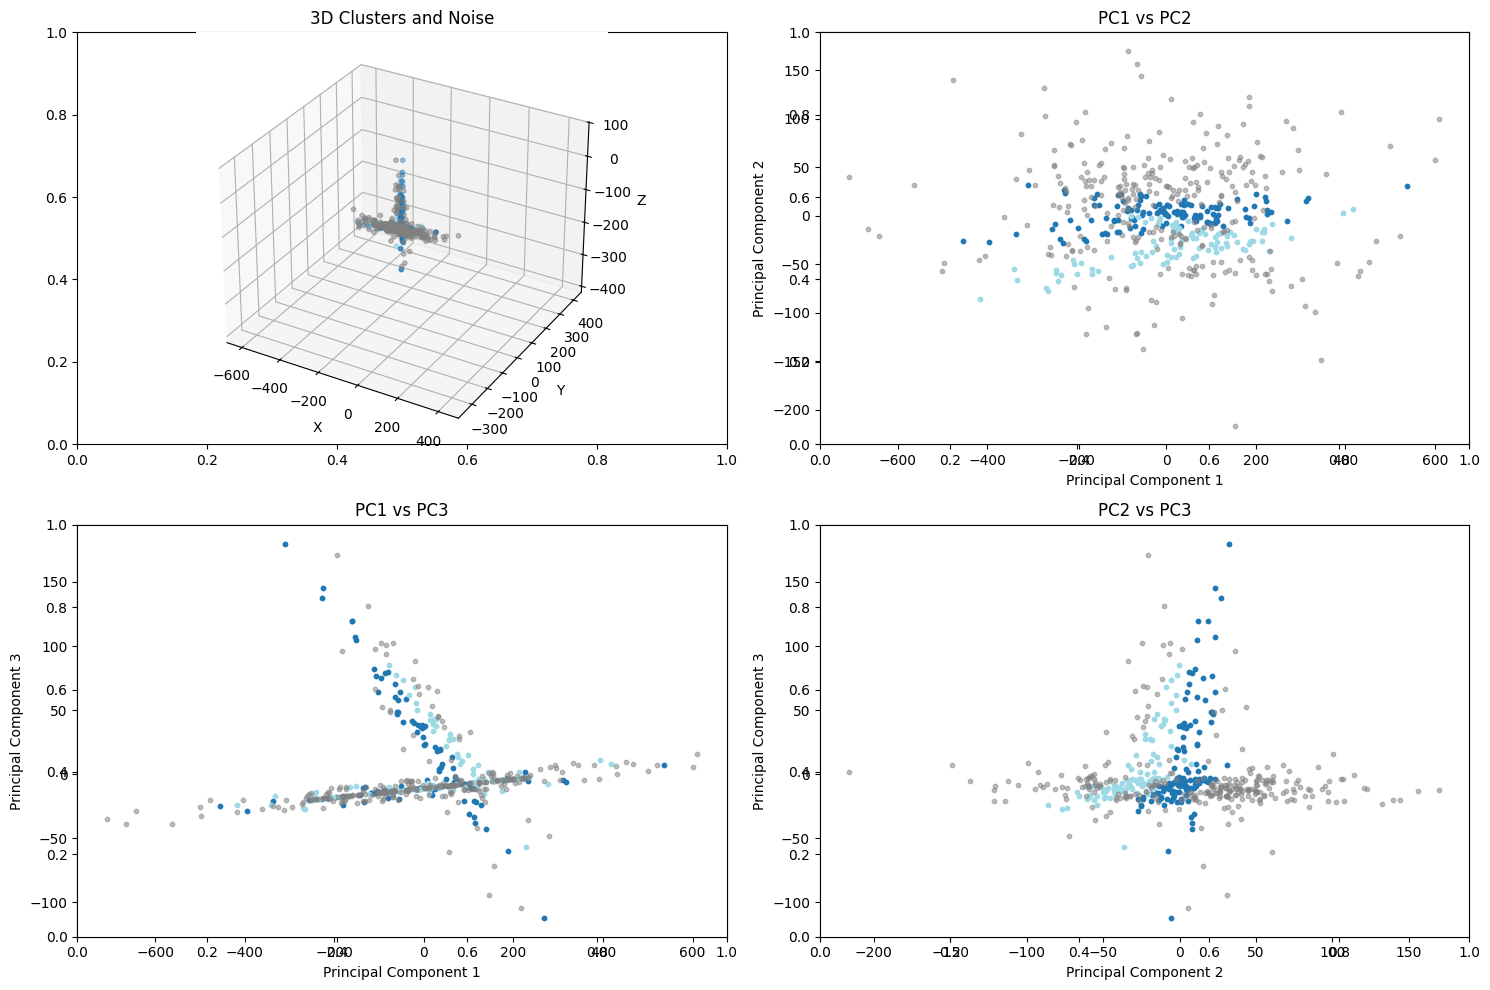

In [382]:
plot_clusters_and_noise(inliers_list, outliers, noisy=True)

In [383]:
denoised_inliers_list, updated_outliers = dbscan_denoising(inliers_list, outliers, eps=3, min_samples=10)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

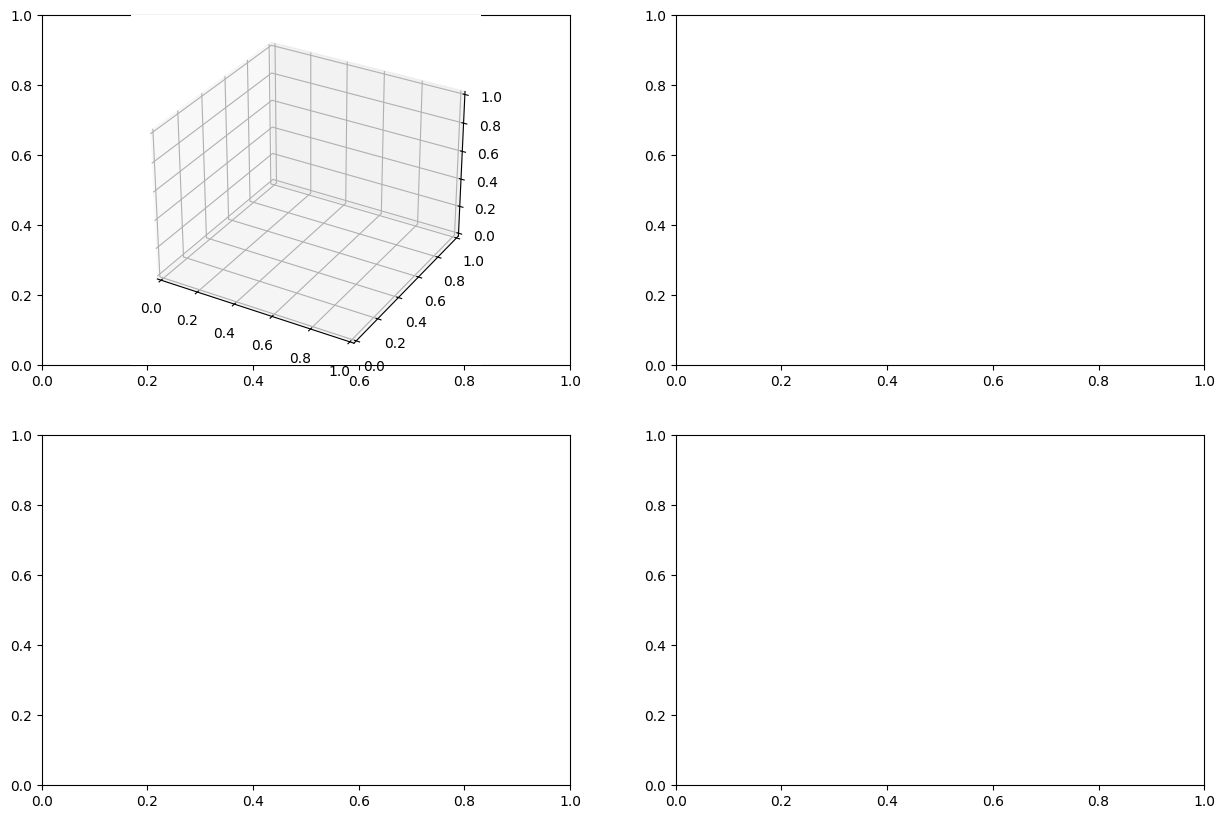

In [384]:
plot_clusters_and_noise(denoised_inliers_list, updated_outliers, noisy=True)